<a href="https://colab.research.google.com/github/deeeplearning-fr/scikit-learn/blob/main/air_passengers_starting_kit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://www.ramp.studio/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (Inria), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [ ]:
%matplotlib inline
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

## Load the dataset using pandas

The training and testing data are located in the folder `data`. They are compressed `csv` file (i.e. `csv.bz2`). We can load the dataset using pandas.

In [ ]:
data = pd.read_csv(
    os.path.join('data', 'train.csv.bz2'), parse_dates=[0]
)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateOfDeparture   8902 non-null   datetime64[ns]
 1   Departure         8902 non-null   object        
 2   Arrival           8902 non-null   object        
 3   WeeksToDeparture  8902 non-null   float64       
 4   log_PAX           8902 non-null   float64       
 5   std_wtd           8902 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 417.4+ KB


So as stated earlier, the column `log_PAX` is the target for our regression problem. The other columns are the features which will be used for our prediction problem. If we focus on the data type of the column, we can see that `DateOfDeparture`, `Departure`, and `Arrival` are of `object` dtype, meaning they are strings.

In [ ]:
data[['DateOfDeparture', 'Departure', 'Arrival']].head()

,DateOfDeparture,Departure,Arrival
0,2012-06-19,ORD,DFW
1,2012-09-10,LAS,DEN
2,2012-10-05,DEN,LAX
3,2011-10-09,ATL,ORD
4,2012-02-21,DEN,SFO


While it makes `Departure` and `Arrival` are the code of the airport, we see that the `DateOfDeparture` should be a date instead of string. We can use pandas to convert this data.

In [ ]:
data.loc[:, 'DateOfDeparture'] = pd.to_datetime(data.loc[:, 'DateOfDeparture'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateOfDeparture   8902 non-null   datetime64[ns]
 1   Departure         8902 non-null   object        
 2   Arrival           8902 non-null   object        
 3   WeeksToDeparture  8902 non-null   float64       
 4   log_PAX           8902 non-null   float64       
 5   std_wtd           8902 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 417.4+ KB


When you will create a submission, `ramp-workflow` will load the data for you and split into a data matrix `X` and a target vector `y`. It will also take care about splitting the data into a training and testing set. These utilities are available in the module `problem.py` which we will load.

In [ ]:
import problem

The function `get_train_data()` loads the training data and returns a pandas dataframe `X` and a numpy vector `y`.

In [ ]:
X, y = problem.get_train_data()

In [ ]:
type(X)

pandas.core.frame.DataFrame

In [ ]:
type(y)

numpy.ndarray

We can check the information of the data `X`

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DateOfDeparture   8902 non-null   object 
 1   Departure         8902 non-null   object 
 2   Arrival           8902 non-null   object 
 3   WeeksToDeparture  8902 non-null   float64
 4   std_wtd           8902 non-null   float64
dtypes: float64(2), object(3)
memory usage: 347.9+ KB


Thus, this is important to see that `ramp-workflow` does not convert the `DateOfDeparture` column into a `datetime` format. Thus, keep in mind that you might need to make a conversion when prototyping your machine learning pipeline later on. Let's check some statistics regarding our dataset.

In [ ]:
print(min(X['DateOfDeparture']))
print(max(X['DateOfDeparture']))

2011-09-01
2013-03-05


In [ ]:
X['Departure'].unique()

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

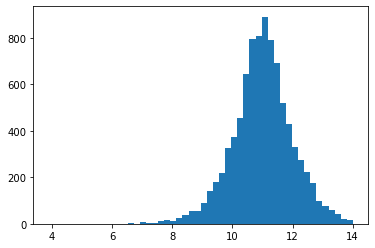

In [ ]:
_ = plt.hist(y, bins=50)

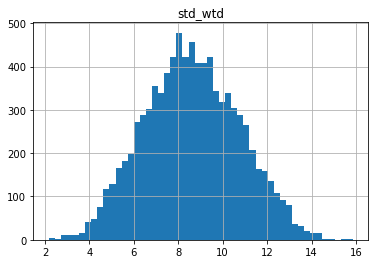

In [ ]:
_ = X.hist('std_wtd', bins=50)

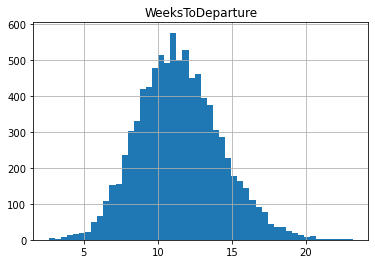

In [ ]:
_ = X.hist('WeeksToDeparture', bins=50)

In [ ]:
X.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


In [ ]:
X.shape

(8902, 5)

In [ ]:
print(y.mean())
print(y.std())

10.99904767212102
0.9938894125318564


## Preprocessing dates

Getting dates into numerical columns is a common operation when time series data is analyzed with non-parametric predictors. The code below makes the following transformations:

- numerical columns for year (2011-2012), month (1-12), day of the month (1-31), day of the week (0-6), and week of the year (1-52)
- number of days since 1970-01-01

In [ ]:
# Make a copy of the original data to avoid writing on the original data
X_encoded = X.copy()

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.isocalendar().week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

In [ ]:
X_encoded.tail(5)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days
8897,2011-10-02,DTW,ATL,9.263158,7.316967,2011,10,2,6,39,15249
8898,2012-09-25,DFW,ORD,12.772727,10.641034,2012,9,25,1,39,15608
8899,2012-01-19,SFO,LAS,11.047619,7.908705,2012,1,19,3,3,15358
8900,2013-02-03,ORD,PHL,6.076923,4.030334,2013,2,3,6,5,15739
8901,2011-11-26,DTW,ATL,9.526316,6.167733,2011,11,26,5,47,15304


We will perform all preprocessing steps within a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/compose.html) which chains together tranformation and estimator steps. This offers offers convenience and safety (help avoid leaking statistics from your test data into the trained model in cross-validation) and the whole pipeline can be evaluated with `cross_val_score`.

To perform the above encoding within a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/compose.html) we will a function and using `FunctionTransformer` to make it compatible with scikit-learn API.

In [ ]:
from sklearn.preprocessing import FunctionTransformer
import holidays

def _encode_dates(X):
    # With pandas < 1.0, we wil get a SettingWithCopyWarning
    # In our case, we will avoid this warning by triggering a copy
    # More information can be found at:
    # https://github.com/scikit-learn/scikit-learn/issues/16191
    X_encoded = X.copy()
    us_holidays = holidays.US()
    
    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    # Encode the DateOfDeparture
    X_encoded.loc[:, 'year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded.loc[:, 'month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded.loc[:, 'day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.isocalendar().week
    X_encoded.loc[:, 'n_days'] = X_encoded['DateOfDeparture'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    X_encoded.loc[:, 'hol_days'] = X_encoded['DateOfDeparture'].apply(
        lambda date: 1 if (date in holidays.US()) else 0)
    # Once we did the encoding, we will not need DateOfDeparture
    return X_encoded.drop(columns=["DateOfDeparture"])

date_encoder = FunctionTransformer(_encode_dates)

In [ ]:
tmp = date_encoder.fit_transform(X)

In [ ]:
tmp[tmp["hol_days"]==1]

,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days,hol_days
24,EWR,BOS,11.000000,8.711759,2012,11,12,0,46,15656,1
54,EWR,LAX,12.818182,8.671993,2011,12,25,6,51,15333,1
68,DEN,LAX,15.034483,11.890821,2012,12,25,1,52,15699,1
77,DEN,ORD,9.631579,7.158604,2013,1,21,0,4,15726,1
119,DEN,ORD,10.176471,7.307832,2011,11,24,3,47,15302,1
...,...,...,...,...,...,...,...,...,...,...,...
8817,JFK,MIA,15.733333,12.564134,2011,12,25,6,51,15333,1
8819,SFO,JFK,16.096774,11.249755,2012,5,28,0,22,15488,1
8843,SFO,LAX,17.705882,11.645078,2012,12,25,1,52,15699,1
8844,MCO,PHL,9.526316,6.432283,2011,12,25,6,51,15333,1


## Random Forests

Tree-based algorithms requires less complex preprocessing than linear-models. We will first present a machine-learning pipeline where we will use a random forest. In this pipeline, we will need to:

- encode the date to numerical values (as presented in the section above);
- oridinal encode the other categorical values to get numerical number;
- keep numerical features as they are.

Thus, we want to perform three different processes on different columns of the original data `X`. In scikit-learn, we can use [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) to perform such processing.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

categorical_encoder = OrdinalEncoder()
categorical_cols = ["Arrival", "Departure"]

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough',  # passthrough numerical columns as they are
)

We can combine our preprocessor with an estimator (`RandomForestRegressor` in this case), allowing us to make predictions.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

n_estimators = 10
max_depth = 10
max_features = 10

regressor = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features#,min_samples_leaf=5
)

pipeline = make_pipeline(date_encoder, preprocessor, regressor)

We can cross-validate our `pipeline` using `cross_val_score`. Below we will have specified `cv=5` meaning KFold cross-valdiation splitting will be used, with 8 folds. The mean squared error regression loss is calculated for each split. The output `score` will be an array of 5 scores from each KFold. The score mean and standard deviation of the 5 scores is printed at the end.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

RMSE: 0.6283 +/- 0.0250


In [ ]:
#!ramp-test --submission starting_kit

## Linear regressor

When dealing with a linear model, we need to one-hot encode categorical variables instead of ordinal encoding and standardize numerical variables. Thus we will:

- encode the date;
- then, one-hot encode all categorical columns, including the encoded date as well;
- standardize the numerical columns.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = [
    "Arrival", "Departure", "year", "month", "day",
    "weekday", "week", "n_days"
]

numerical_scaler = StandardScaler()
numerical_cols = ["WeeksToDeparture", "std_wtd"]

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    (numerical_scaler, numerical_cols)
)

We can now combine our `preprocessor` with the `LinearRegression` estimator in a `Pipeline`:

In [ ]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

pipeline = make_pipeline(date_encoder, preprocessor, regressor)

And we can evaluate our linear-model pipeline:

In [ ]:
scores = cross_val_score(
    pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

RMSE: 0.6117 +/- 0.0149


### Test grid search and Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
lasso=Lasso()
pipL = make_pipeline( date_encoder, preprocessor, lasso)
pipL_gs = GridSearchCV(
    pipL,
    {"lasso__alpha":[0.00001, 0.0001, 0.01]}
)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.10)
pipL_gs.fit(X_train, y_train)

In [ ]:
lasso=Lasso()
pipL = make_pipeline( date_encoder, preprocessor, lasso)
pipL_gs = GridSearchCV(
    pipL,
    {"lasso__alpha":[0.00001, 0.0001, 0.01]}
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.10)

In [ ]:
pipL_gs.fit(X_train, y_train)

/home/peter/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.22821354759185, tolerance: 0.6387185401787862
  model = cd_fast.sparse_enet_coordinate_descent(
/home/peter/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331.01463346245384, tolerance: 0.6371123962129355
  model = cd_fast.sparse_enet_coordinate_descent(
/home/peter/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.01636597892013, tolerance: 0.6285972686841081
  model = cd_fast.sparse_enet_coordinate_descent(
/home/peter/anaconda3/lib/python3.8/site-packages/sklearn/lin

GridSearchCV(estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _encode_dates at 0x7fec3149caf0>)),
                                       ('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Arrival',
                                                                          'Departure',
                                                                          'year',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                           

In [ ]:
pipL_gs.best_params_

{'lasso__alpha': 0.0001}

In [ ]:
pipL_gs.best_estimator_.steps[-1][1].alpha

0.0001

In [ ]:
pipL_gs.cv_results_

{'mean_fit_time': array([7.13713937, 6.03071251, 1.12473645]),
 'std_fit_time': array([0.03533106, 0.28460367, 0.01887271]),
 'mean_score_time': array([0.25607538, 0.2563077 , 0.25720119]),
 'std_score_time': array([0.0008828 , 0.00213678, 0.00135228]),
 'param_lasso__alpha': masked_array(data=[1e-05, 0.0001, 0.01],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lasso__alpha': 1e-05},
  {'lasso__alpha': 0.0001},
  {'lasso__alpha': 0.01}],
 'split0_test_score': array([0.62011337, 0.62706323, 0.41771701]),
 'split1_test_score': array([0.64666052, 0.65529856, 0.46811574]),
 'split2_test_score': array([0.60801378, 0.61410272, 0.42689959]),
 'split3_test_score': array([0.60262507, 0.61203399, 0.43874222]),
 'split4_test_score': array([0.61859979, 0.62804545, 0.44002117]),
 'mean_test_score': array([0.61920251, 0.62730879, 0.43829915]),
 'std_test_score': array([0.01519957, 0.01543859, 0.0170045 ]),
 'rank_test_score': array([2, 1,

In [ ]:
#!ramp-test --submission starting_kit_lin

In [ ]:
#!ramp-test --submission starting_kit_Ridge

# Merging external data

The objective in this RAMP data challenge is to find good data that can be correlated to flight traffic. We will use some weather data (saved in `submissions/starting_kit`) to provide an example of how to merge external data in a scikit-learn pipeline.

Your external data will need to be included in your submissions folder - see [RAMP submissions](#RAMP-submissions) for more details.

First we will define a function that merges the external data to our feature data.

In [ ]:
# when submitting a kit, the `__file__` variable will corresponds to the
# path to `estimator.py`. However, this variable is not defined in the
# notebook and thus we must define the `__file__` variable to imitate
# how a submission `.py` would work.
__file__ = os.path.join('submissions', 'starting_kit', 'estimator.py')
filepath = os.path.join(os.path.dirname(__file__), 'external_data.csv')
filepath

'submissions/starting_kit/external_data.csv'

In [ ]:
pd.read_csv(filepath).tail(20)

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
11020,2013-02-14,LGA,8,4,1,1,-2,-6,82,60,37,1016,1012,1006,16,16,10,26,13,29.0,T,4,Rain-Snow,295
11021,2013-02-15,LGA,12,7,3,2,0,-3,76,60,44,1016,1015,1013,16,15,11,37,13,42.0,0.00,4,NaN,210
11022,2013-02-16,LGA,6,3,0,1,-4,-10,82,64,45,1014,1012,1007,16,16,13,39,20,52.0,0.51,8,Rain-Snow,2
11023,2013-02-17,LGA,0,-3,-7,-11,-14,-17,49,40,31,1016,1008,1004,16,16,16,58,40,72.0,0.00,5,NaN,321
11024,2013-02-18,LGA,2,-2,-7,-12,-15,-17,51,39,26,1024,1022,1016,16,16,16,50,26,64.0,0.00,1,NaN,278
11025,2013-02-19,LGA,8,4,1,5,-2,-12,89,62,35,1023,1012,1005,16,15,6,40,18,56.0,4.06,6,Rain,195
11026,2013-02-20,LGA,4,1,-3,-7,-11,-14,52,43,33,1015,1011,1006,16,16,16,50,33,64.0,0.00,4,NaN,284
11027,2013-02-21,LGA,2,-1,-4,-10,-11,-13,55,48,41,1025,1018,1015,16,16,16,50,32,64.0,0.00,2,NaN,306
11028,2013-02-22,LGA,4,1,-3,-1,-7,-9,70,63,56,1029,1027,1025,16,16,16,29,14,39.0,T,6,NaN,50
11029,2013-02-23,LGA,4,3,2,2,1,-1,92,84,76,1025,1017,1009,16,7,0,34,18,42.0,6.86,8,Rain,53


In [ ]:
def _merge_external_data(X):
    filepath = os.path.join(
        os.path.dirname(__file__), 'external_data.csv'
    )
    
    X = X.copy()  # to avoid raising SettingOnCopyWarning
    # Make sure that DateOfDeparture is of dtype datetime
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    # Parse date to also be of dtype datetime
    data_weather = pd.read_csv(filepath, parse_dates=["Date"])

    X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC', 'Events']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival', 'Max TemperatureC': 'MaxTempArriv', 'Events':'EventsArr'})
    X_merged = pd.merge(
        X, X_weather, how='left', on=['DateOfDeparture', 'Arrival'], sort=False
    )
    # add temp of the departure
    X_weather = data_weather[['Date', 'AirPort', 'Min TemperatureC', 'Events']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Departure', 'Min TemperatureC': 'MinTempArriv', 'Events':'EventsDep'})
    X_merged = pd.merge(
        X_merged, X_weather, how='left', on=['DateOfDeparture', 'Departure'], sort=False
    )
    X_merged.loc[:,["EventsArr","EventsDep"]]=X_merged.loc[:,["EventsArr","EventsDep"]].fillna(value="good")
    return X_merged

data_merger = FunctionTransformer(_merge_external_data)

Double check that our function works:

In [ ]:
data_merger.fit_transform(X).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,MaxTempArriv,EventsArr,MinTempArriv,EventsDep
0,2012-06-19,ORD,DFW,12.875000,9.812647,34,good,26,good
1,2012-09-10,LAS,DEN,14.285714,9.466734,33,good,27,good
2,2012-10-05,DEN,LAX,10.863636,9.035883,22,Fog,-1,Rain-Snow
3,2011-10-09,ATL,ORD,11.480000,7.990202,27,good,16,good
4,2012-02-21,DEN,SFO,11.450000,9.517159,16,good,-4,good


Use `FunctionTransformer` to make our function compatible with scikit-learn API:

We can now assemble our pipeline using the same `data_merger` and `preprocessor` as above:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

categorical_encoder = OrdinalEncoder()
categorical_cols = ["Arrival", "Departure", "EventsArr", "EventsDep"]

mymd=data_merger.fit_transform(X)[["EventsArr", "EventsDep"]]
enc = OrdinalEncoder()
enc.fit(mymd)
print(enc.categories_)

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough',  # passthrough numerical columns as they are
)

[array(['Fog', 'Fog-Rain', 'Fog-Rain-Hail-Thunderstorm', 'Fog-Rain-Snow',
       'Fog-Rain-Snow-Thunderstorm', 'Fog-Rain-Thunderstorm', 'Fog-Snow',
       'Rain', 'Rain-Hail-Thunderstorm', 'Rain-Snow',
       'Rain-Snow-Thunderstorm', 'Rain-Thunderstorm', 'Snow',
       'Thunderstorm', 'good'], dtype=object), array(['Fog', 'Fog-Rain', 'Fog-Rain-Hail-Thunderstorm', 'Fog-Rain-Snow',
       'Fog-Rain-Snow-Thunderstorm', 'Fog-Rain-Thunderstorm', 'Fog-Snow',
       'Rain', 'Rain-Hail-Thunderstorm', 'Rain-Snow',
       'Rain-Snow-Thunderstorm', 'Rain-Thunderstorm',
       'Rain-Thunderstorm-Tornado', 'Snow', 'Thunderstorm', 'good'],
      dtype=object)]


In [ ]:
n_estimators = 10
max_depth = 10
max_features = 10

regressor = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features
)

pipeline = make_pipeline(data_merger, date_encoder, preprocessor, regressor)

In [ ]:
scores = cross_val_score(
    pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

ValueError: Found unknown categories ['Rain-Thunderstorm-Tornado'] in column 3 during transform

## Feature importances

We can check the feature importances using the function [`sklearn.inspection.permutation_importances`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html). Since the first step of our pipeline adds the new external feature `Max TemperatureC`, we want to apply this transformation after adding `Max TemperatureC`, to check the importances of all features. Indeed, we can perform `sklearn.inspection.permutation_importances` at any stage of the pipeline, as we will see later on.


The code below:

* performs `transform` on the first step of the pipeline (`pipeline[0]`) producing the transformed train (`X_train_augmented`) and test (`X_test_augmented`) data
* the transformed data is used to fit the pipeline from the second step onwards

Note that pipelines can be sliced. `pipeline[0]` obtains the first step (tuple) of the pipeline. You can further slice to obtain either the transformer/estimator (first item in each tuple) or column list (second item within each tuple) inside each tuple. For example `pipeline[0][0]` obtains the transformer of the first step of the pipeline (first item of the first tuple).

In [ ]:
print(pipeline)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7fec2cc9e280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7fec3149caf0>)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Arrival', 'Departure'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, max_features=10,
                                       n_estimators=10))])


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

merger = pipeline[0]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipeline[1:]
predictor.fit(X_train_augmented, y_train).score(X_test_augmented, y_test)

0.617276332720553

With the fitted pipeline, we can now use `permutation_importance` to calculate feature importances:

In [ ]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented, y_train, n_repeats=5
)

Here, we plot the permutation importance using the training set. The higher the value, more important the feature is.

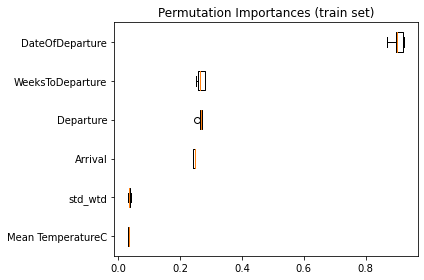

In [ ]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

We can replicate the same processing on the test set and see if we can observe the same trend.

In [ ]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_test_augmented, y_test, n_repeats=10
)

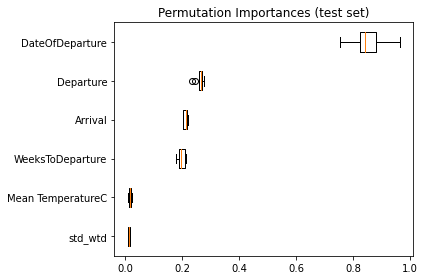

In [ ]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_test_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

With the current version of scikit-learn, it is not handy but still possible to check the feature importances at the latest stage of the pipeline (once all features have been preprocessed).

The difficult part is to get the name of the features.

In [ ]:
preprocessor = pipeline[:-1]
predictor = pipeline[-1]

X_train_augmented = preprocessor.transform(X_train)
X_test_augmented = preprocessor.transform(X_test)

Let's find out the feature names (in the future, scikit-learn will provide a `get_feature_names` function to handle this case).

In [ ]:
categorical_cols_name = categorical_cols
passthrough_cols_name = (
    pipeline[:2].transform(X_train[:1])  # Take only one sample to go fast
    .columns[pipeline[2].transformers_[-1][-1]]
    .tolist()
)
feature_names = np.array(
    categorical_cols_name + passthrough_cols_name
)
feature_names

array(['Arrival', 'Departure', 'WeeksToDeparture', 'std_wtd',
       'Mean TemperatureC', 'year', 'month', 'day', 'weekday', 'week',
       'n_days', 'hol_days'], dtype='<U17')

We can repeat the previous processing at this finer grain, where the transformed date columns are included.

In [ ]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented, y_train, n_repeats=5
)

Here, we plot the permutation importance using the training set. Basically, higher the value, more important is the feature.

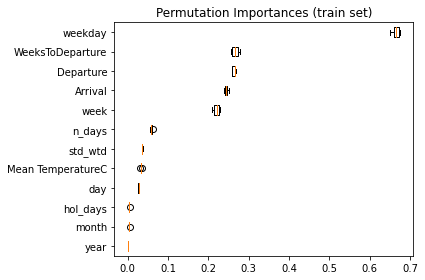

In [ ]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=feature_names[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

We can replicate the same processing on the test set and see if we can observe the same trend.

In [ ]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_test_augmented, y_test, n_repeats=10
)

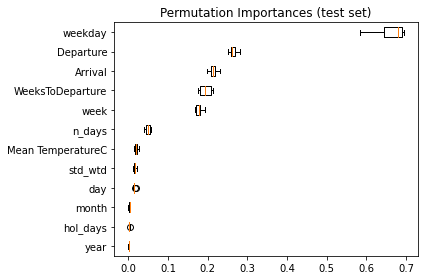

In [ ]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=feature_names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).